# Compile unitaries

In this notebook we want use the unitary compilation model.

In [ ]:
from genQC.imports import *
from genQC.pipeline.diffusion_pipeline import DiffusionPipeline
from qiskit import QuantumCircuit
from genQC.inference.infer_compilation import generate_comp_tensors, get_gate_and_U_acc
from genQC.printing import display_colums
import genQC.platform.qcircuit_dataset_construction as data_const
import qiskit.quantum_info as qi
import genQC.util as util
import ast

In [ ]:
device = util.infer_torch_device()  # use cuda if we can
util.MemoryCleaner.purge_mem()      # clean existing memory alloc

[INFO]: Cuda device has a capability of 8.6 (>= 8), allowing tf32 matmul.


In [ ]:
def str_cond_to_gate_indices(y):   # helper function, used to check if only allowed gates were used by the model!
    assert y[:15] == "Compile using: "
    c            = ast.literal_eval(y[15:]) 
    gate_classes = data_const.gate_pool_to_gate_classes(pipeline.gate_pool)
    gate_clrs    = [0] + [gate_classes[ic] for ic in c]  # 0 is empty, always allowed!
    return gate_clrs

## Setup and load

Load the pre-trained model

In [ ]:
model_path = "../../saves/qc_unet_config_Compilation_3_qubit/"
pipeline   = DiffusionPipeline.from_config_file(model_path, device)  

[INFO]: `genQC.models.unet_qc.QC_Compilation_UNet` instantiated from given config on cuda.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder` instantiated from given config on cuda.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. No save_path` provided. No state dict loaded.


Set 20 sample steps and use rescaled guidance-formula.

In [ ]:
pipeline.guidance_sample_mode = "rescaled"
pipeline.scheduler.set_timesteps(20) 
g = 7

The model was trained with a gate pool of:

In [ ]:
pipeline.gate_pool

[qiskit.circuit.library.standard_gates.h.HGate,
 qiskit.circuit.library.standard_gates.x.CXGate,
 qiskit.circuit.library.standard_gates.z.ZGate,
 qiskit.circuit.library.standard_gates.x.XGate,
 qiskit.circuit.library.standard_gates.x.CCXGate,
 qiskit.circuit.library.standard_gates.swap.SwapGate]

## Compile a unitary

Compile a given unitary $U$. Note, there has to be a solution with the `pipeline.gate_pool` in order to find the exact solution.

In [ ]:
def compile_and_plot(U, prompt):
    U_r, U_i = torch.Tensor(np.real(U)), torch.Tensor(np.imag(U))
    U_tensor = torch.stack([U_r, U_i], dim=0)
    
    out_tensor                           = generate_comp_tensors(pipeline, prompt, U_tensor, samples, num_of_qubits, num_of_qubits, max_gates, g, unique=True)
    _, _, _, _, _, comb_corr_qc, _, _, _ = get_gate_and_U_acc(out_tensor, str_cond_to_gate_indices(prompt), U_tensor, pipeline.gate_pool, num_of_qubits, max_gates)
    comb_corr_qc                         = sorted(comb_corr_qc, key=lambda x: len(x.data)) #sort to get the shortest solutions

    fig, axs = plt.subplots(1,4, figsize=(18,5), constrained_layout=True)
    axs[0].set_title(f"{prompt}")
    for qc,ax in zip(comb_corr_qc, axs.flatten()): 
        qc.draw("mpl", plot_barriers=False, ax=ax)
    plt.show()

In [ ]:
samples       = 512
num_of_qubits = 3
max_gates     = 12

In [ ]:
prompt = "Compile using: ['h', 'cx', 'z', 'x', 'ccx', 'swap']" # model was trained with phrases like this, allow full gate set
prompt

"Compile using: ['h', 'cx', 'z', 'x', 'ccx', 'swap']"

#### Exercise 1

Inspired from [(quantumcomputing.stackexchange.com/questions/13821/generate-a-3-qubit-swap-unitary-in-terms-of-elementary-gates/13826)](https://quantumcomputing.stackexchange.com/questions/13821/generate-a-3-qubit-swap-unitary-in-terms-of-elementary-gates/13826). Note, this unitary WAS in the training set.

In [ ]:
U = np.matrix([[1,0,0,0,0,0,0,0],
               [0,1,0,0,0,0,0,0],
               [0,0,1,0,0,0,0,0],
               [0,0,0,0,1,0,0,0],
               [0,0,0,1,0,0,0,0],
               [0,0,0,0,0,1,0,0],
               [0,0,0,0,0,0,1,0],
               [0,0,0,0,0,0,0,1]], dtype=np.complex128) 

assert np.allclose(U.H@U, np.identity(2**num_of_qubits)) and np.allclose(U@U.H, np.identity(2**num_of_qubits)) #check if unitary

Plot correct (exact) compiled circuits:

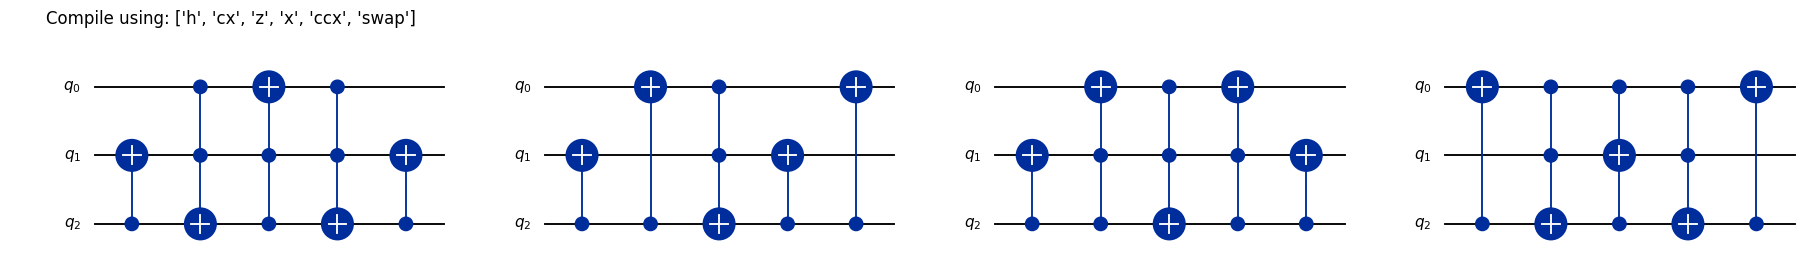

In [ ]:
compile_and_plot(U, prompt)

#### Exercise 2

Inspired from [(quantumcomputing.stackexchange.com/questions/12439/procedures-and-intuition-for-designing-simple-quantum-circuits/12440)](https://quantumcomputing.stackexchange.com/questions/12439/procedures-and-intuition-for-designing-simple-quantum-circuits/12440). Note, this unitary WAS in the training set.

In [ ]:
U = np.matrix([[1,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,1],
               [0,1,0,0,0,0,0,0],
               [0,0,1,0,0,0,0,0],
               [0,0,0,1,0,0,0,0],
               [0,0,0,0,1,0,0,0],
               [0,0,0,0,0,1,0,0],
               [0,0,0,0,0,0,1,0]], dtype=np.complex128) 

assert np.allclose(U.H@U, np.identity(2**num_of_qubits)) and np.allclose(U@U.H, np.identity(2**num_of_qubits)) #check if unitary

Plot correct (exact) compiled circuits:

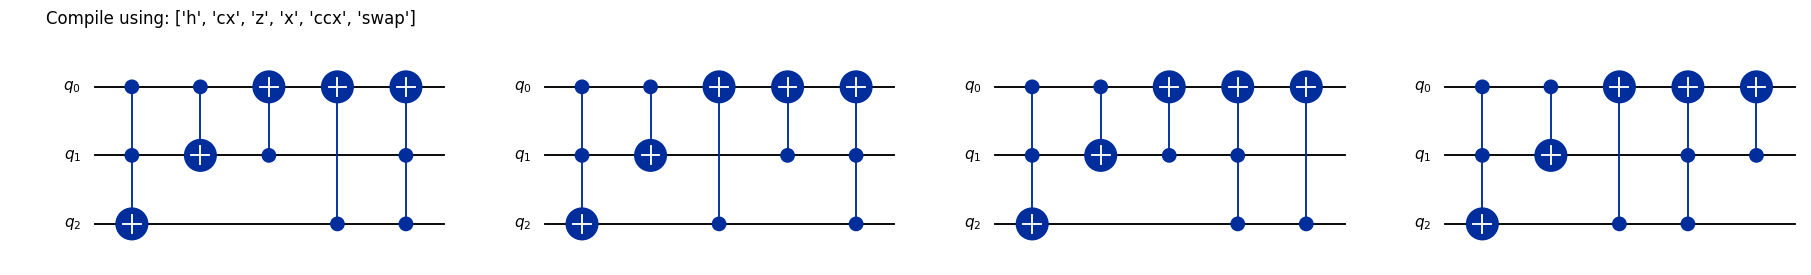

In [ ]:
compile_and_plot(U, prompt)

#### Exercise 3

A randomly generated unitary (from a random circuit). This unitary WAS NOT in the training set, it is new to the model!

In [ ]:
U = np.matrix([[ 0.70710678,  0.        ,  0.        , 0.        ,  0.70710678,  0.        , 0.        ,  0.        ],
               [ 0.        , -0.70710678,  0.        , 0.        ,  0.        , -0.70710678, 0.        ,  0.        ],
               [-0.70710678,  0.        ,  0.        , 0.        ,  0.70710678,  0.        , 0.        ,  0.        ],
               [ 0.        ,  0.70710678,  0.        , 0.        ,  0.        , -0.70710678, 0.        ,  0.        ],
               [ 0.        ,  0.        ,  0.70710678, 0.        ,  0.        ,  0.        , 0.        ,  0.70710678],
               [ 0.        ,  0.        ,  0.        , 0.70710678,  0.        ,  0.        , 0.70710678,  0.        ],
               [ 0.        ,  0.        , -0.70710678, 0.        ,  0.        ,  0.        , 0.        ,  0.70710678],
               [ 0.        ,  0.        ,  0.        ,-0.70710678,  0.        ,  0.        , 0.70710678,  0.        ]], dtype=np.complex128)

assert np.allclose(U.H@U, np.identity(2**num_of_qubits)) and np.allclose(U@U.H, np.identity(2**num_of_qubits)) #check if unitary

Plot correct (exact) compiled circuits:

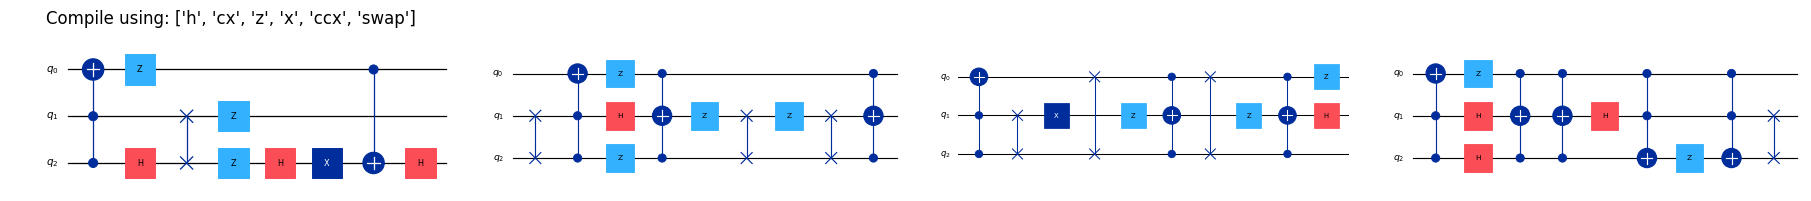

In [ ]:
compile_and_plot(U, prompt)

## Transpile and discover

Set an initial circuit we want to transpile, optimize or use for discovering sub-arrangements:

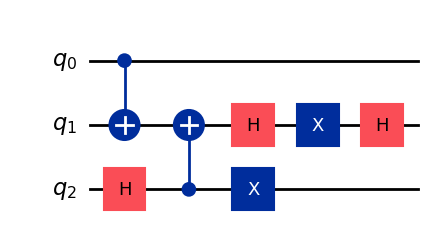

In [ ]:
qc = QuantumCircuit(3)
qc.h(2)
qc.cx(0,1)
qc.cx(2,1)
qc.h(1)
qc.x(1)
qc.h(1)
qc.x(2)

U = qi.Operator(qc).to_matrix() # the unitary of the circuit

#-----------------------------------------

fig = qc.draw("mpl")
fig

We set different gate pool targets to see what the model gives us:

In [ ]:
cs_1 = f"Compile using: {[x().name for x in pipeline.gate_pool]}", "all"

cs_2 = "Compile using: ['h', 'cx', 'z', 'ccx']" , "no x, no swap"    
cs_3 = "Compile using: ['h', 'cx', 'x', 'ccx']" , "no z, no swap"    
cs_4 = "Compile using: ['h', 'x', 'ccx']"       , "no cx, no z, no swap" 
cs_5 = "Compile using: ['h', 'z', 'x', 'ccx']"  , "no cx, no swap"  

cs = [cs_1, cs_2, cs_3, cs_4, cs_5]
cs

[("Compile using: ['h', 'cx', 'z', 'x', 'ccx', 'swap']", 'all'),
 ("Compile using: ['h', 'cx', 'z', 'ccx']", 'no x, no swap'),
 ("Compile using: ['h', 'cx', 'x', 'ccx']", 'no z, no swap'),
 ("Compile using: ['h', 'x', 'ccx']", 'no cx, no z, no swap'),
 ("Compile using: ['h', 'z', 'x', 'ccx']", 'no cx, no swap')]

In [ ]:
samples       = 512
num_of_qubits = 3
max_gates     = 12

Compile with the different gate-sets and plot correct (exact) compiled circuits. Note, some of the circuits might look the same but the gate time-sequences are distinct. Qiskit reorders "parallel" gates to make smaller plots.

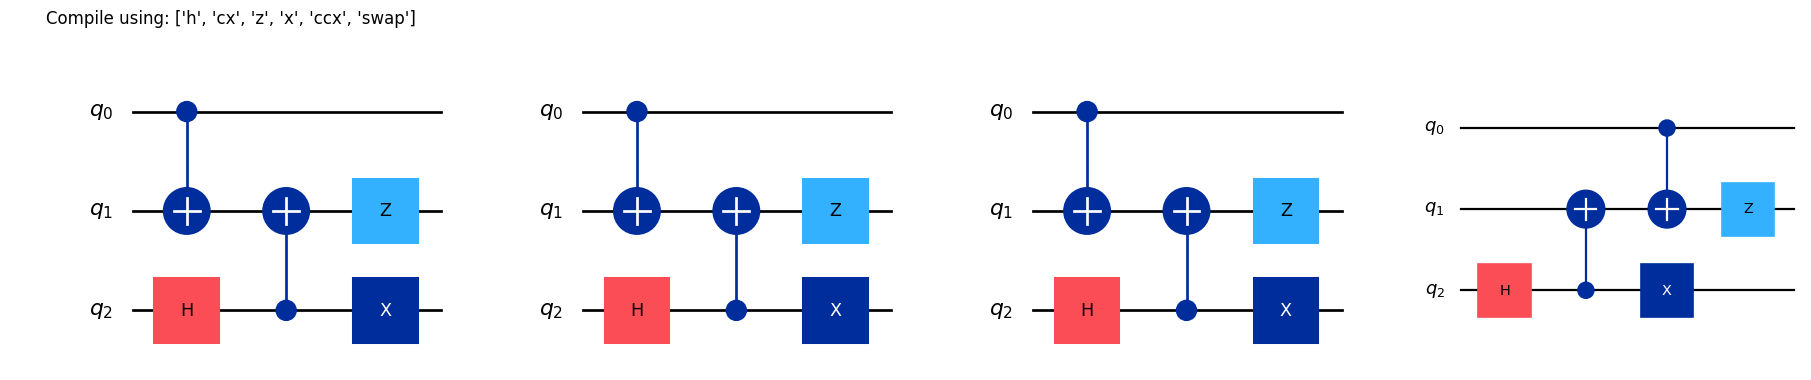

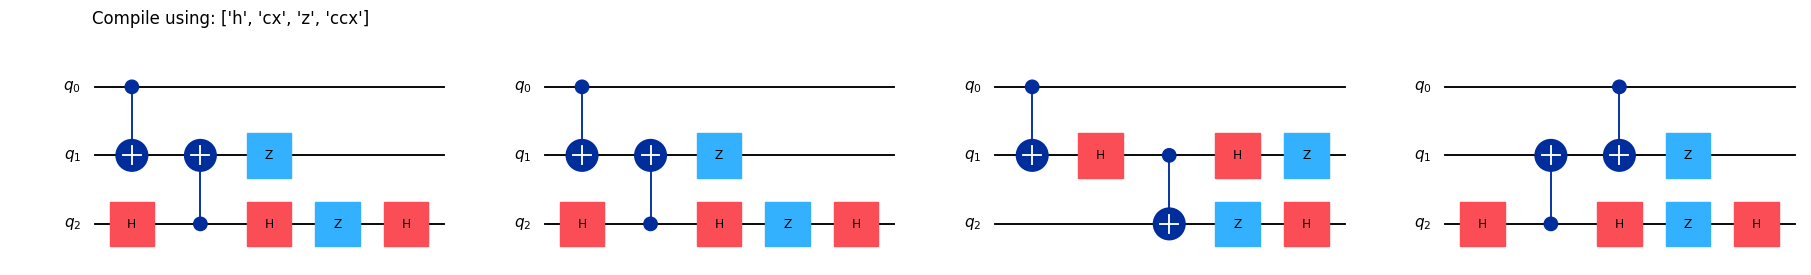

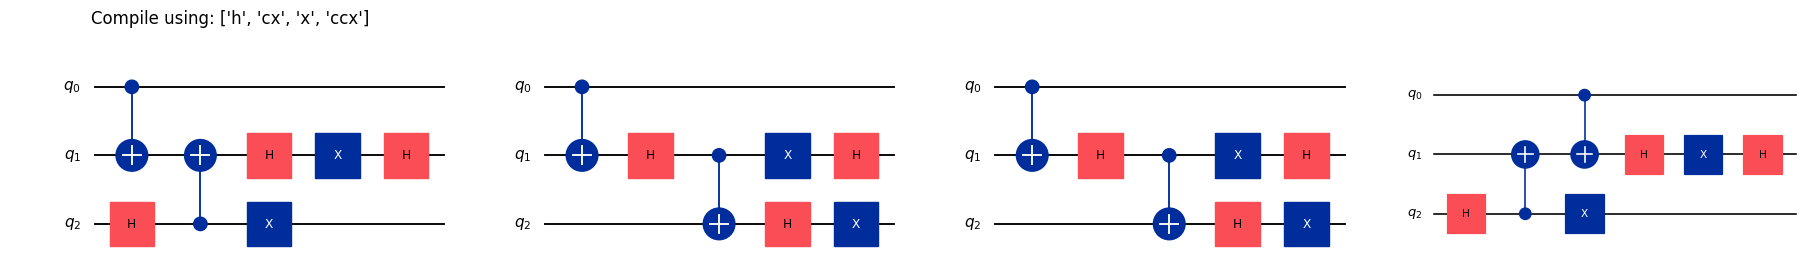

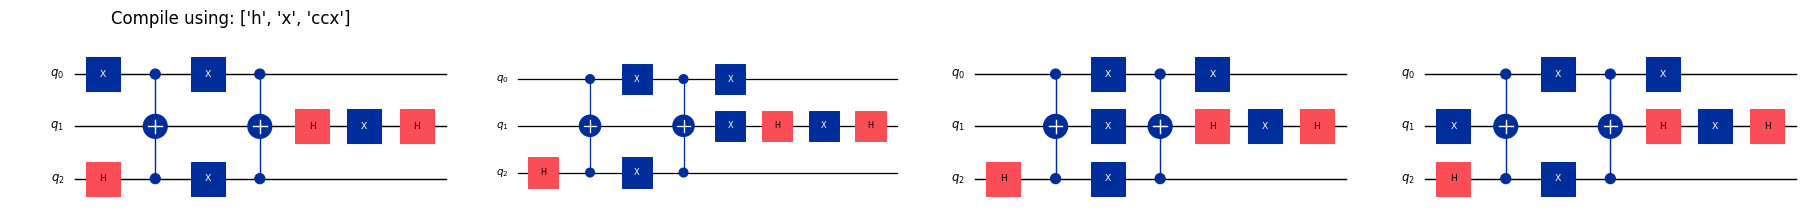

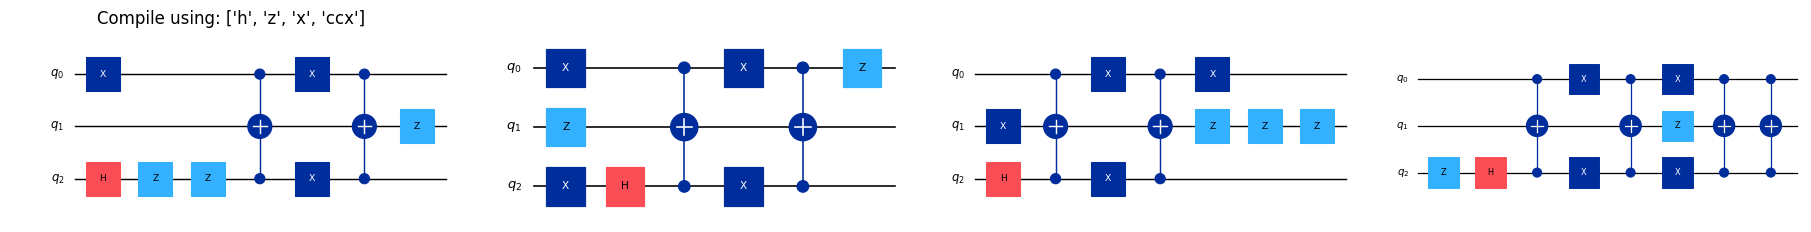

In [ ]:
for c, note in cs: compile_and_plot(U, c)